In [1]:
import os
import numpy as np
import cv2
import glob
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from lesson_functions import *
%matplotlib inline

In [2]:
#define object point for calibaration
nx = 9
ny = 6

In [3]:
def camera_calib(images):
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    

    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)


    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
   
    # Do camera calibration given object points and image points
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    
    return mtx, dist

In [ ]:
# Make a list of calibration images
calib_images = glob.glob('camera_cal/calibration*.jpg')

#perform calibaration
mtx, dist = camera_calib(calib_images)
# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "camera_dist.p", "wb" ) )

In [4]:
# load pickled distortion matrix
with open('camera_dist.p', mode='rb') as f:
    dist_pickle = pickle.load(f)
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]

In [5]:
def undistort(image, display = False):
    #img_size = (image.shape[1], image.shape[0])
    undst_img = cv2.undistort(image, mtx, dist, None, mtx)
    if display == True:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=15)
        ax2.imshow(undst_img)
        ax2.set_title('Undistorted Image', fontsize=15)
    
    return undst_img

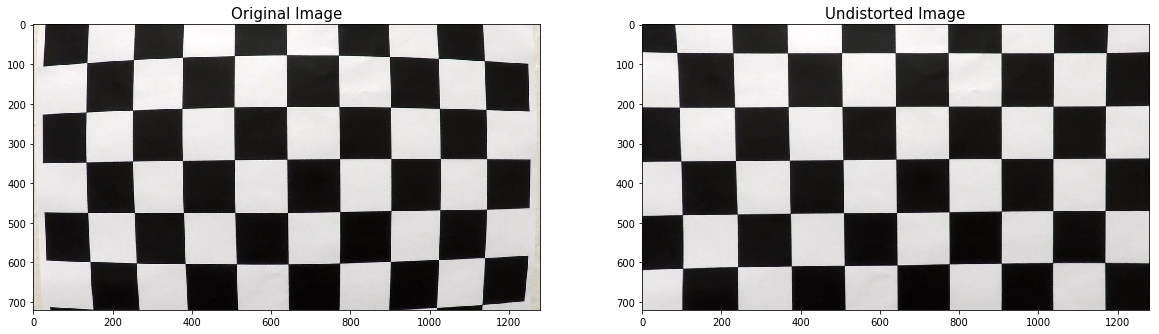

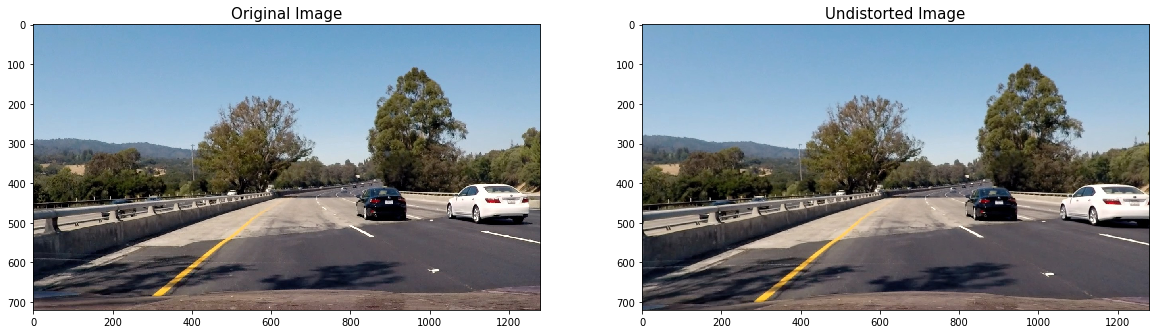

In [6]:
# Visualize undistortion on test images
img = mpimg.imread('camera_cal/calibration1.jpg')
_= undistort(img, True)
img = mpimg.imread('test_images/test4.jpg')
_= undistort(img, True)

In [7]:
def compute_binary_img(image, display = False, sx_thresh=(50, 150), h_thresh=(15, 100), s_thresh=(100, 255)):
    
    img = np.copy(image)
    img = undistort(img)
    
    #sobel x binary img
    sxbinary = abs_sobel_thresh(img, orient='x', thresh = sx_thresh)
    
    # Convert to HLS color space 
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    
    h_channel = hls[:,:,0]
    s_channel = hls[:,:,2]
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    
    combined = np.zeros_like(s_channel)
    combined[(sxbinary == 1) | ((h_binary == 1) & (s_binary == 1))] = 1

    color_binary = np.uint8(np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary, h_binary)) * 255)
    
    if display == True:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(image)
        ax1.set_title('Original Image', fontsize=15)
        ax2.imshow(combined, cmap = 'gray')
        ax2.set_title('Undistorted Thresholded Binary Image', fontsize=15)
    
    return combined
    

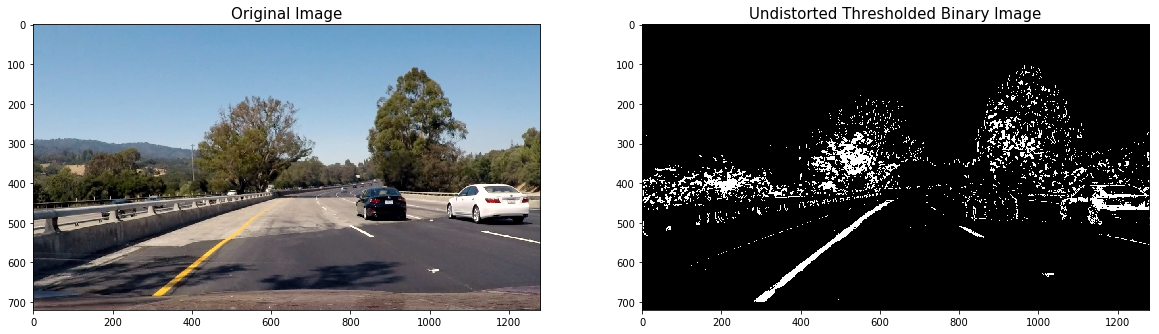

In [8]:
_= compute_binary_img(img, display = True)

In [9]:
def unwarp_img(image, display = False):
    h,w = image.shape[:2]
    #Define 4 source points (which takes shape of trapezoid)
    src = np.float32([[170, h], [550, 480],[750, 480], [1200, h]])
    # Define 4 destination points (which takes shape of rectangle)
    dst = np.float32([[250, h], [250, 0], [1050, 0], [1050, h]])
    
    
    # Compute the perspective transform, M, given source and destination points.
    M = cv2.getPerspectiveTransform(src, dst)
    # Compute the inverse perspective transform.
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp an image using the perspective transform, M
    unwarped = cv2.warpPerspective(image, M, (w,h), flags=cv2.INTER_LINEAR)
    
    if display == True:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        ax1.imshow(image, cmap = 'gray')
        ax1.set_title('Binary Image', fontsize=15)
        ax2.imshow(unwarped, cmap = 'gray')
        ax2.set_title('Unwarped Image', fontsize=15)
    
    
    return unwarped, M, Minv

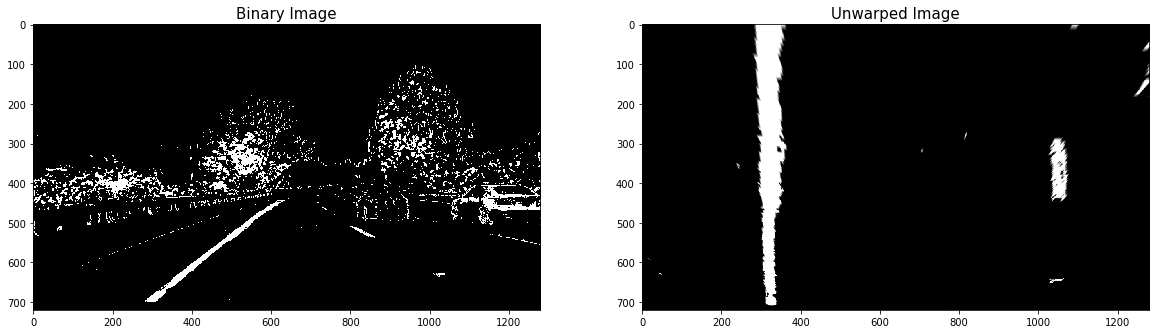

In [10]:
_,_,_ = unwarp_img(compute_binary_img(img), display = True)

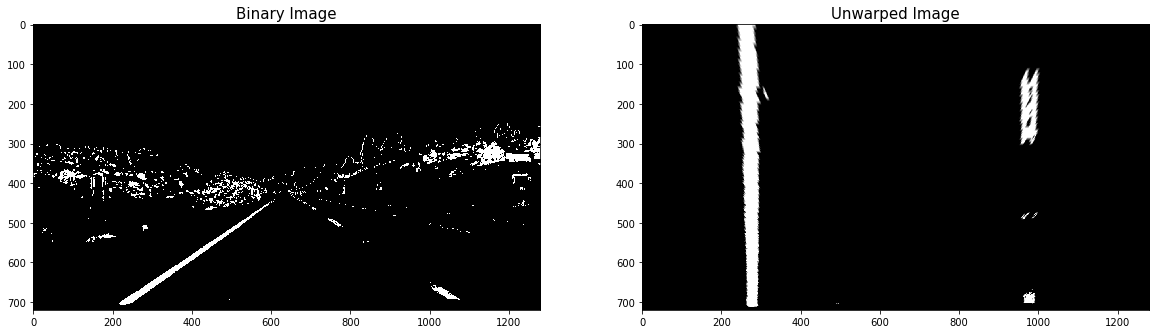

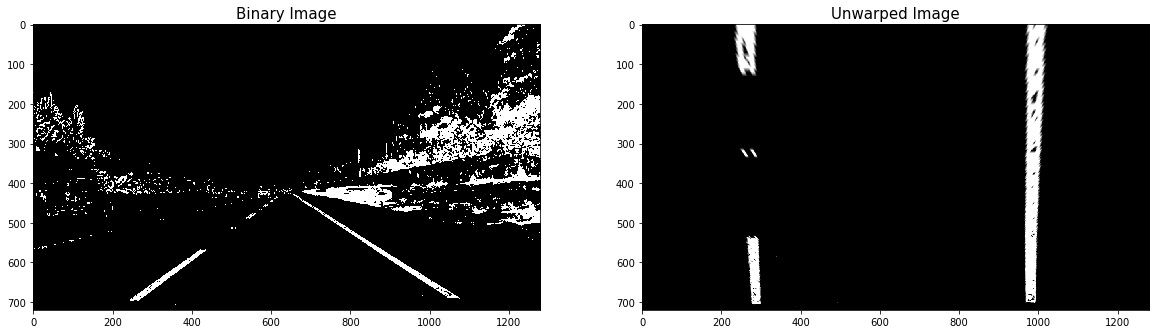

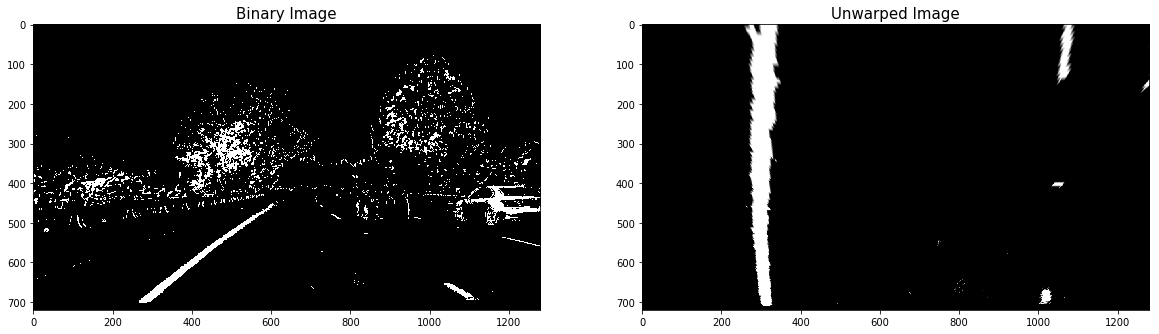

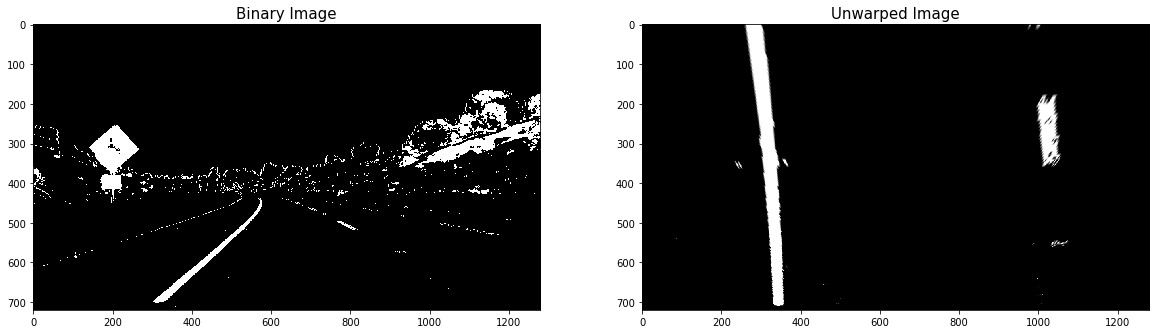

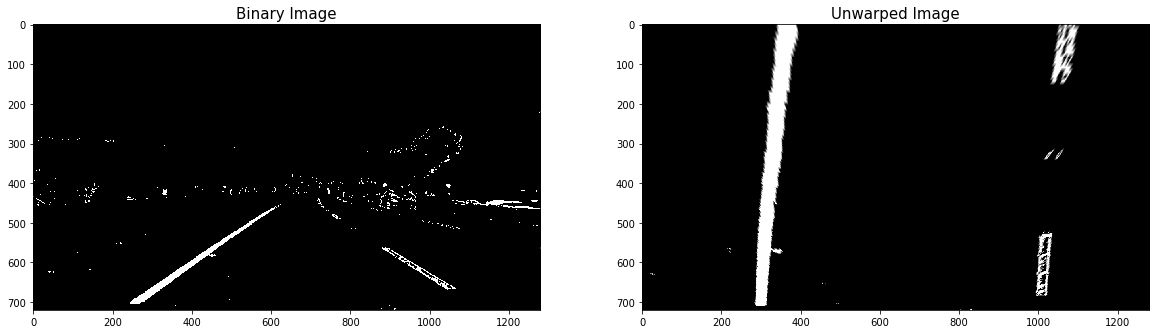

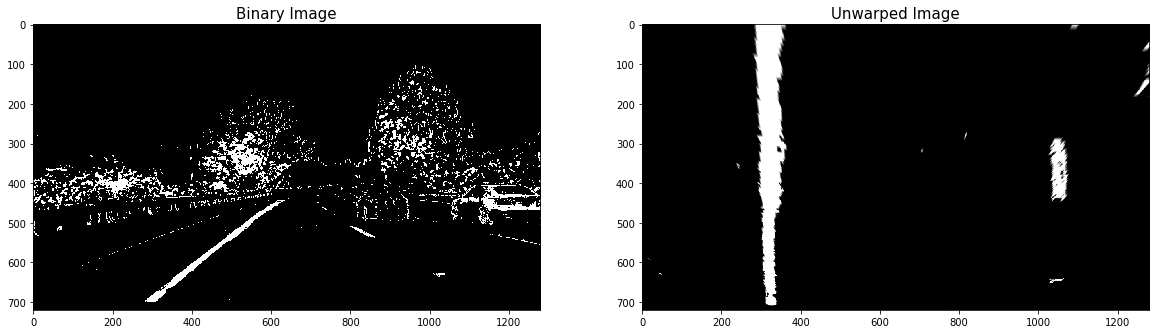

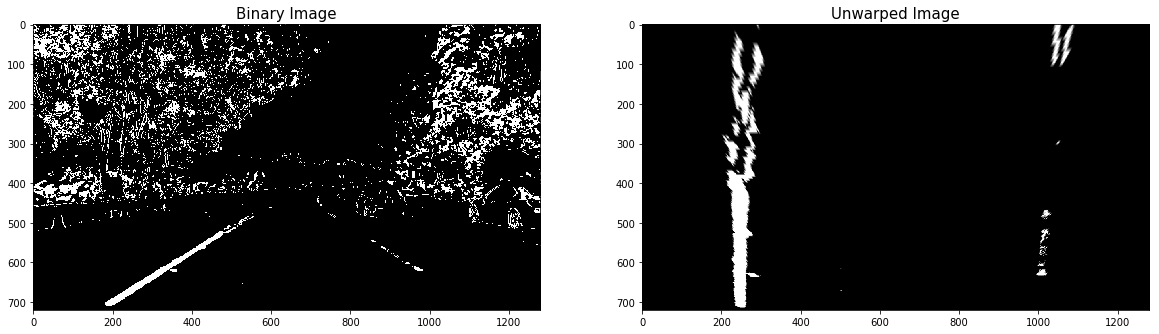

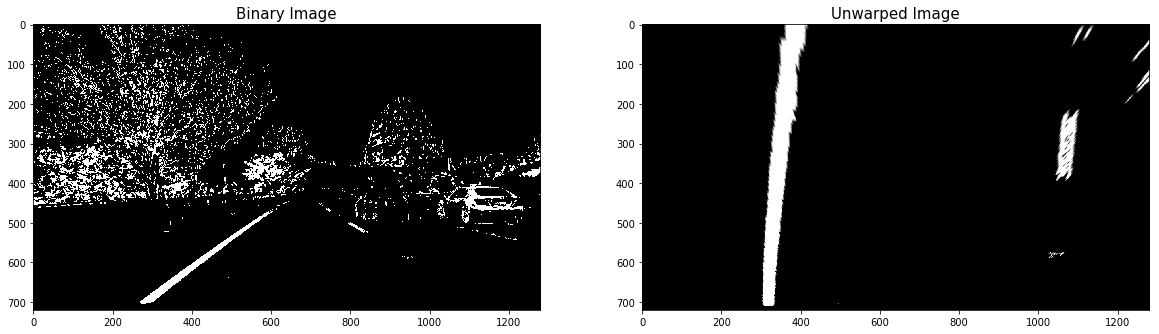

In [11]:
# Make a list of example images
imgs = glob.glob('./test_images/*.jpg')

for img_loc in imgs:
    img = mpimg.imread(img_loc)
    _,_,_ = unwarp_img(compute_binary_img(img), display = True)
    

In [12]:
# Returns polyfit for left and right lanes. 
def sliding_window_polyfit(binary_warped, display = False):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
       
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    left_fit, right_fit = (None, None)
    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
        
    
    if left_fit is not None and right_fit is not None and display == True:
        
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        
        #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        plt.plot(histogram)
        plt.title('Histogram', fontsize=15)
        
        
                
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
        
        
        window_img = np.zeros_like(out_img)
        # Draw the windows on the visualization image

        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                      ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                      ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.figure()
        plt.subplot(121)
        plt.imshow(binary_warped, cmap= 'gray')
        plt.title('Binary Unwarped')
        plt.subplot(122)
        plt.imshow(result)
        plt.title('Poly Fit', fontsize=15)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        

    return left_fit, right_fit

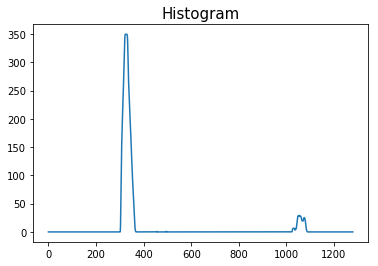

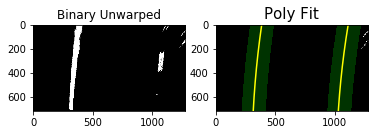

In [13]:
bin_unwarp_img,_,_ = unwarp_img(compute_binary_img(img), display = False)
_,_ =sliding_window_polyfit(bin_unwarp_img, display = True)

In [14]:
def polyfit_previousline(binary_warped, left_fit_prev, right_fit_prev):
    left_fit, right_fit = (None, None)

    
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit_prev[0]*(nonzeroy**2) + left_fit_prev[1]*nonzeroy + 
    left_fit_prev[2] - margin)) & (nonzerox < (left_fit_prev[0]*(nonzeroy**2) + 
    left_fit_prev[1]*nonzeroy + left_fit_prev[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit_prev[0]*(nonzeroy**2) + right_fit_prev[1]*nonzeroy + 
    right_fit_prev[2] - margin)) & (nonzerox < (right_fit_prev[0]*(nonzeroy**2) + 
    right_fit_prev[1]*nonzeroy + right_fit_prev[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit a second order polynomial to each
    if len(leftx) != 0:
        left_fit = np.polyfit(lefty, leftx, 2)
    if len(rightx) != 0:
        right_fit = np.polyfit(righty, rightx, 2)
        
    return left_fit, right_fit

In [15]:
def cal_curvature(width, ploty, left_fitx, right_fitx):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/900 # meters per pixel in x dimension

    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the radii of curvature
    left_curverad =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5)/np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5)/np.absolute(2*right_fit_cr[0])

    
    car_pos = width / 2
    lane_center = (left_fitx[719] + right_fitx[719]) / 2
    #distance from center of lane line
    vehicle_offset = (lane_center-car_pos)*xm_per_pix
    
    #radius of curvature is in meters
    radius_of_curvature = np.mean([left_curverad, right_curverad])
    return radius_of_curvature, vehicle_offset

def draw_lane_area(undist, warped, Minv, left_fit, right_fit):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Generate x and y values for plotting
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    color_unwarp = cv2.warpPerspective(color_warp, Minv, (warped.shape[1], warped.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, color_unwarp, 0.3, 0)
        
    radius_of_curvature, vehicle_offset = cal_curvature(warped.shape[1], ploty, left_fitx, right_fitx)
    
    if vehicle_offset < 0:
        direction = 'right'
    elif vehicle_offset > 0:
        direction = 'left'
    
    font = cv2.FONT_HERSHEY_COMPLEX
    cv2.putText(result, 'Radius of Curvature ={:04.2f}'.format(radius_of_curvature) + ' (m)',
                (20,70), font, 1,(100,255,0),2, cv2.LINE_AA)
    cv2.putText(result, 'Car is {:04.3f}'.format(abs(vehicle_offset))+' (m) '+ direction + ' of center',
                (20,130), font, 1,(100,255,0),2, cv2.LINE_AA)
    return result

In [16]:
def pipeline(image, left_fit_prev=None, right_fit_prev=None):
    unwarped, _, Minv = unwarp_img(compute_binary_img(image))
    if left_fit_prev is None or right_fit_prev is None:
        left_fit, right_fit = sliding_window_polyfit(unwarped)
    else:
        left_fit, right_fit = polyfit_previousline(unwarped, left_fit_prev, right_fit_prev)

    if left_fit is not None and right_fit is not None:
        image = draw_lane_area(image, unwarped, Minv, left_fit, right_fit)
    return image, left_fit, right_fit

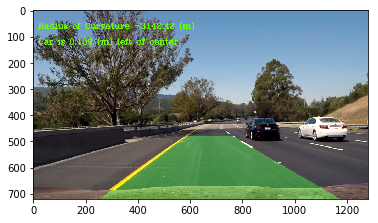

In [17]:
img = mpimg.imread('test_images/test6.jpg')
result,_,_ = pipeline(img)
plt.imshow(result)
plt.show()

In [18]:
#create a pipline for video
class Lanes():
    def __init__(self):
        self.left_fit = None
        self.right_fit = None

def pipeline_video(image):
    output, left_fit, right_fit = pipeline(image, lanes.left_fit, lanes.right_fit)
    lanes.left_fit = left_fit
    lanes.right_fit = right_fit
    return output

In [19]:
#Import functions for processing video
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [20]:
lanes = Lanes()
out_dir='./'
output = out_dir+'processed_project_video1.mp4'
clip = VideoFileClip("project_video.mp4")
out_clip = clip.fl_image(pipeline_video) 
%time out_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video ./processed_project_video1.mp4
[MoviePy] Writing video ./processed_project_video1.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:33<00:00,  3.67it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./processed_project_video1.mp4 

Wall time: 5min 34s


In [ ]:
output = out_dir+'processed_challenge_video.mp4'
clip = VideoFileClip("challenge_video.mp4")
out_clip = clip.fl_image(pipeline_video) 
%time out_clip.write_videofile(output, audio=False)